/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== sample predictions (first 10) ===
 price           category             brand  actual_highly_rated  predicted_highly_rated  predicted_probability
 63.21            Luggage             FOTAP                    1                       1               0.838794
125.66            Watches           AIYIRUO                    1                       1               0.749056
 35.99            Wallets           NALACAL                    0                       0               0.285760
 59.00    Made for Amazon            Bourge                    0                       0               0.368667
 75.10 Most-Loved Fashion           BALENNZ                    1                       1               0.976063
135.32            Luggage      DELSEY PARIS                    1                       1               0.779165
155.22        Accessories Smarter LifeStyle                    1                       1               0.761461
 59.00 Most-Loved Fashion      Steve Madden                    1 

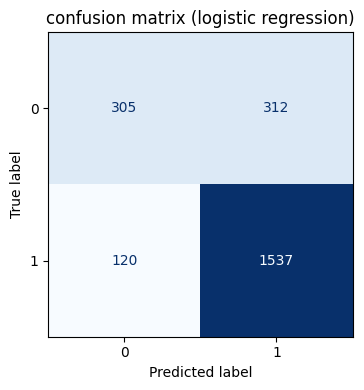

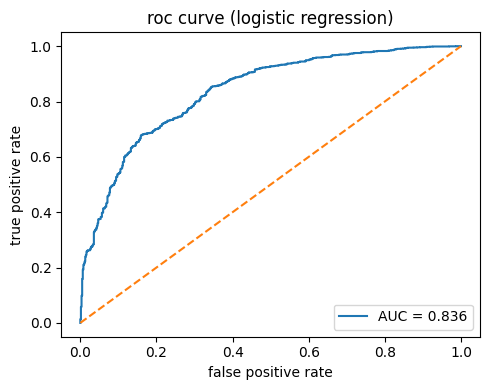

importances len: 3 | names len: 3
 feature  importance_mean  importance_std
category         0.175818        0.009945
   brand         0.138541        0.004343
   price        -0.000251        0.000120


In [ ]:
# import tools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# load data
df = pd.read_csv("/content/products_clean (4).csv")

# create a binary target, where 1 is the ratings that are >= 4.0
if "rating" not in df.columns:
    raise ValueError("expected a rating column")
df["highly_rated"] = (pd.to_numeric(df["rating"], errors="coerce") >= 4.0).astype("Int64")

# separate columns, with price as numerical value, and category and brand as category values
possible_num = ["price"]
possible_cat = ["category", "brand"]
num_feats = [c for c in possible_num if c in df.columns]
cat_feats = [c for c in possible_cat if c in df.columns]
X_cols = num_feats + cat_feats

# create x and y columns , with x as the numerical and categorical features, and y as the ratings >= 4.0
df_model = df.dropna(subset=["highly_rated"]).copy()
y = df_model["highly_rated"].astype(int)
X = df_model[X_cols].copy()

# split data into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# prepare model
# fill empty cells with column's median
num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

# fill in text values and turn categories into numbers
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
# combine numerical and categorical transforming into one transformer
preprocess = ColumnTransformer([
    ("num", num_tf, num_feats) if num_feats else ("num", "drop", []),
    ("cat", cat_tf, cat_feats) if cat_feats else ("cat", "drop", [])
])

# create logistic regression model
clf = LogisticRegression(max_iter=1000)
pipe = Pipeline([
    ("prep", preprocess),
    ("clf", clf)
])

# clean the training data and teach the logistic regression model to find patterns between the features
# (price, category, brand) and the target (highly rated or not).
pipe.fit(X_tr, y_tr)

# make predictions on the test set
y_pred = pipe.predict(X_te)
try:
    y_proba = pipe.predict_proba(X_te)[:, 1]
except Exception:
    y_proba = None

# create model predictions per brand and category

preds_df = X_te.copy()
preds_df["actual_highly_rated"] = y_te.values
preds_df["predicted_highly_rated"] = y_pred
if y_proba is not None:
    preds_df["predicted_probability"] = y_proba

# test console
print("\n=== sample predictions (first 10) ===")
print(preds_df.head(10).to_string(index=False))

# build table for metrics
metrics = {
    "accuracy": accuracy_score(y_te, y_pred),
    "precision": precision_score(y_te, y_pred, zero_division=0),
    "recall": recall_score(y_te, y_pred, zero_division=0),
    "f1": f1_score(y_te, y_pred, zero_division=0),
}
if y_proba is not None:
    try:
        metrics["roc_auc"] = roc_auc_score(y_te, y_proba)
    except Exception:
        metrics["roc_auc"] = np.nan
else:
    metrics["roc_auc"] = np.nan

print("\n=== classification metrics ===")
for k, v in metrics.items():
    print(f"{k:>9}: {v:.4f}")

# create confusion matrix plot
cm = confusion_matrix(y_te, y_pred, labels=[0, 1])
fig_cm, ax_cm = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(
    ax=ax_cm, cmap="Blues", values_format="d", colorbar=False)
ax_cm.set_title("confusion matrix (logistic regression)")
fig_cm.tight_layout()
plt.show()

# create roc curve plot
if y_proba is not None and not np.isnan(metrics.get("roc_auc", np.nan)):
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    fig_roc, ax_roc = plt.subplots(figsize=(5, 4))
    auc_val = metrics.get("roc_auc", float("nan"))
    ax_roc.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    ax_roc.plot([0, 1], [0, 1], "--")
    ax_roc.set(xlabel="false positive rate", ylabel="true positive rate",
               title="roc curve (logistic regression)")
    ax_roc.legend(loc="lower right")
    fig_roc.tight_layout()
    plt.show()

# run permutation importance to identify which features of products lead to the highest ratings

from sklearn.inspection import permutation_importance
feature_names = np.array(X_te.columns) if hasattr(X_te, "columns") else np.array([f"col_{i}" for i in range(X_te.shape[1])])
scorer = "roc_auc"
r = permutation_importance(
    estimator=pipe,
    X=X_te,
    y=y_te,
    n_repeats=10,
    random_state=42,
    scoring=scorer,
    n_jobs=-1
)

print("importances len:", r.importances_mean.shape[0], "| names len:", len(feature_names))

imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance_mean": r.importances_mean,
        "importance_std":  r.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

print(imp_df.head(15).to_string(index=False))

